In [303]:
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from torchsummary import summary
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


(28, 56)
5 0


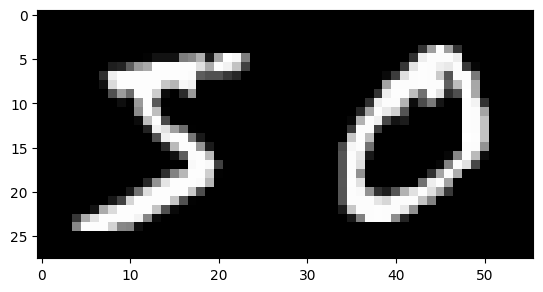

In [358]:
import struct

with open('aux/MNIST/raw/train-images-idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))
print(np.concatenate((data[0, :, :], data[1, :, :]), axis=1).shape)
plt.imshow(np.concatenate((data[0, :, :], data[1, :, :]), axis=1), cmap='gray')

with open('aux/MNIST/raw/train-labels-idx1-ubyte', 'rb') as l:
    magic, size = struct.unpack(">II", l.read(8))
    lbls = np.fromfile(l, dtype=np.dtype(np.uint8).newbyteorder('>'))
    lbls = lbls.reshape((size,))  # (Optional)
print(lbls[0], lbls[1])


In [359]:
train_numbers = []
train_labels = []
for i in range(lbls.shape[0]-1):
    number = np.concatenate((data[i, :, :], data[i+1, :, :]), axis=1)
    label = (lbls[i], lbls[i + 1])
    train_numbers.append(number)
    train_labels.append(label)
print(np.array(train_numbers).shape)
print(np.array(train_labels).shape)


(59999, 28, 56)
(59999, 2)


(28, 56)
7 2


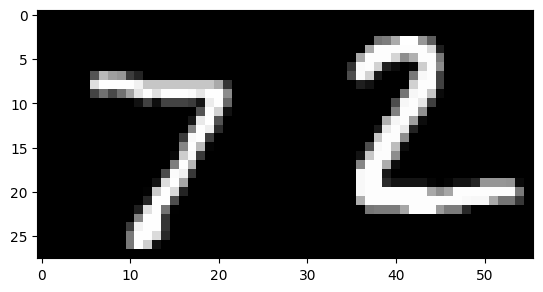

In [360]:
with open('aux/MNIST/raw/t10k-images-idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))
print(np.concatenate((data[0, :, :], data[1, :, :]), axis=1).shape)
plt.imshow(np.concatenate((data[0, :, :], data[1, :, :]), axis=1), cmap='gray')

with open('aux/MNIST/raw/t10k-labels-idx1-ubyte', 'rb') as l:
    magic, size = struct.unpack(">II", l.read(8))
    lbls = np.fromfile(l, dtype=np.dtype(np.uint8).newbyteorder('>'))
    lbls = lbls.reshape((size,))  # (Optional)
print(lbls[0], lbls[1])


In [361]:
valid_numbers = []
valid_labels = []
for i in range(lbls.shape[0]-1):
    number = np.concatenate((data[i, :, :], data[i+1, :, :]), axis=1)
    label = (lbls[i], lbls[i + 1])
    valid_numbers.append(number)
    valid_labels.append(label)
print(np.array(valid_numbers).shape)
print(np.array(valid_labels).shape)


(9999, 28, 56)
(9999, 2)


In [142]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_labels)
valid_labels = mlb.fit_transform(valid_labels)


In [145]:
train_labels[0]


array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [195]:
class NumbersDataset(Dataset):
    def __init__(self, labels, images):
        self.labels = labels
        self.images = images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx])
        label = torch.tensor(self.labels[idx])
        return torch.unsqueeze(image, dim=0)/255, label.float()


train_data = NumbersDataset(train_labels, train_numbers)
valid_data = NumbersDataset(valid_labels, valid_numbers)


In [197]:
valid_data.__getitem__(0)


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]))

In [196]:
train_loader = DataLoader(
    train_data,
    batch_size=64, shuffle=True
)
valid_loader = DataLoader(
    valid_data,
    batch_size=64, shuffle=True
)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])


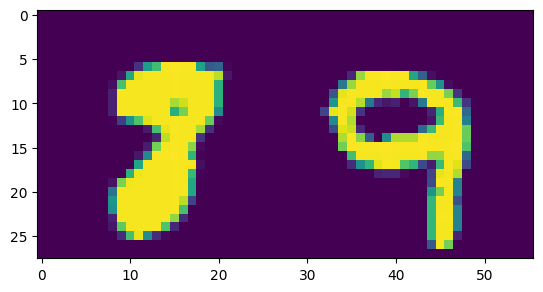

In [198]:
for images, labels in train_loader:
    for im in images:
        # print(im)
        # im =im
        plt.imshow(im[0])
        # plt.imshow(torch.permute(im,(1,2,0)))
        # label = i[1]
        # print(label)
        break
    for l in labels:
        print(l)
        break
    break


In [203]:
class MLClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(12544, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.linear(x)
        return x


In [204]:
model = MLClassifier()
summary(model, (1, 28, 56))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 56]             320
              ReLU-2           [-1, 32, 28, 56]               0
         MaxPool2d-3           [-1, 32, 14, 28]               0
           Flatten-4                [-1, 12544]               0
            Linear-5                   [-1, 10]         125,450
           Sigmoid-6                   [-1, 10]               0
Total params: 125,770
Trainable params: 125,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.96
Params size (MB): 0.48
Estimated Total Size (MB): 1.44
----------------------------------------------------------------


In [205]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


MLClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=10, bias=True)
    (2): Sigmoid()
  )
)

In [206]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

In [207]:
epoch_losses_train = []
epoch_losses_valid = []

for epoch in tqdm(np.arange(10)):
    batch_losses = []
    model.train()
    for numbers, labels in train_loader:
        print(numbers.shape)
        pred = model(numbers.to(device))
        optimizer.zero_grad()
        print('PRED', pred.shape)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    epoch_losses_train.append(np.mean(batch_losses))

    batch_losses = []
    model.eval()
    for numbers, labels in valid_loader:
        pred = model(numbers.to(device))
        loss = criterion(pred, labels)
        batch_losses.append(loss.item())
    epoch_losses_valid.append(np.mean(batch_losses))

    print(
        f'Epoch {epoch} train_loss: {epoch_losses_train[-1]:.4f}, valid: {epoch_losses_valid[-1]:.4f}')


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])
PRED torch.Size([64, 10])
torch.Size([64, 1, 28, 56])


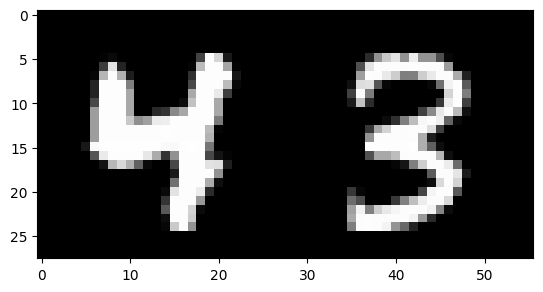

In [362]:
im = np.concatenate((data[85, :, :], data[9429, :, :]), axis=1)
plt.imshow(im, cmap='gray')


In [346]:
dummy_input = torch.randn(1, 1, 28, 56).to(device)
torch.onnx.export(model, dummy_input, 'model/numbers.onnx',
                  input_names=['data'], output_names=['output'],
                  dynamic_axes={'data':[1]},
                  export_params=True)


/Users/nikole/miniforge3/lib/python3.10/site-packages/torch/onnx/utils.py:1520: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input data
  warnings.warn(


In [391]:
im = torch.tensor(im)/255
save_image(im, 'images/test.jpg')

/var/folders/y_/74x7dnc13xs1f5pkllccjdv80000gn/T/ipykernel_31893/3703897272.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  im = torch.tensor(im)/255


In [368]:
import onnxruntime
from onnxruntime import InferenceSession
import json

onnx_model = 'model/numbers.onnx'

img = read_image('images/test.jpg')
transform = T.transforms.Grayscale()
img = transform(img)
img = img.clone().detach()
img = torch.unsqueeze(img, 0)/255
# img[...,:3]
# img = np.dot(img[...,:3], [0, 0.587, 0.114])
# img
# img.resize((1, 1, 28, 56))
img.shape
data = json.dumps({'data': img.tolist()})
data = np.array(json.loads(data)['data']).astype('float32')


In [366]:
session = onnxruntime.InferenceSession(onnx_model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
# print(input_name)
# print(output_name)


data
output


In [390]:
result = session.run([output_name], {input_name: data})
print(result)

max_indices = np.argsort(np.array(result).squeeze())[-2:][::-1]
prediction = "".join(map(lambda x: str(x), max_indices.tolist()))
print(prediction)


[array([[-5.9604645e-08, -5.9604645e-08,  3.8743019e-07,  9.9999762e-01,
         9.9999940e-01,  6.5714121e-05, -5.9604645e-08,  1.2814999e-06,
         9.2949867e-03,  4.4703484e-06]], dtype=float32)]
43
